# Counterfeit Medicine Detection using Deep Learning

## Project Overview
This project uses **Transfer Learning** with a pre-trained ResNet-18 model to classify medicine images as either **Authentic** or **Counterfeit**.


## Dataset Structure
- Training set: Used to teach the model
- Validation set: Used to check model performance during training
- Test set: Used to evaluate final model performance

---



In [1]:
# Import necessary libraries
import os
import random
import numpy as np
import pandas as pd
from pathlib import Path
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt

# PyTorch libraries for deep learning
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.transforms as T
import torchvision.models as models

# Machine learning evaluation metrics
from sklearn.metrics import classification_report, confusion_matrix

# Set random seed for reproducibility (so results are consistent)
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

print("✓ All libraries imported successfully!")
print(f"✓ Random seed set to {SEED} for reproducibility")


✓ All libraries imported successfully!
✓ Random seed set to 42 for reproducibility


## Step 2: Load and Explore the Dataset

We'll load the dataset from CSV files that contain information about the images and their labels (authentic or counterfeit).



In [2]:
# Define the paths to our dataset folders
# Update this path to match your dataset location
PROJECT_ROOT = Path('/Users/subhammahapatra/Downloads/Projects/AiMl')
DATA_DIR = PROJECT_ROOT / 'data' / 'raw'
TRAIN_DIR = DATA_DIR / 'train'
VALID_DIR = DATA_DIR / 'valid'
TEST_DIR = DATA_DIR / 'test'

# Check if the dataset folders exist
if not DATA_DIR.exists():
    print(f"⚠️ Warning: Dataset folder not found at {DATA_DIR}")
    print("Please update the DATA_DIR path to match your dataset location")
else:
    print(f"✓ Project root: {PROJECT_ROOT}")
    print(f"✓ Dataset found at: {DATA_DIR}")
    print(f"  - Training folder: {TRAIN_DIR}")
    print(f"  - Validation folder: {VALID_DIR}")
    print(f"  - Test folder: {TEST_DIR}")



✓ Project root: /Users/subhammahapatra/Downloads/Projects/AiMl
✓ Dataset found at: /Users/subhammahapatra/Downloads/Projects/AiMl/data/raw
  - Training folder: /Users/subhammahapatra/Downloads/Projects/AiMl/data/raw/train
  - Validation folder: /Users/subhammahapatra/Downloads/Projects/AiMl/data/raw/valid
  - Test folder: /Users/subhammahapatra/Downloads/Projects/AiMl/data/raw/test


In [3]:
# Function to load annotation data from CSV files
def load_annotations(split_dir):
    """
    Load annotation data from CSV file.
    
    Args:
        split_dir: Path to the folder containing the CSV file
        
    Returns:
        DataFrame with image paths and labels
    """
    csv_path = split_dir / '_annotations.csv'
    
    if not csv_path.exists():
        print(f"⚠️ Warning: {csv_path} not found")
        return None
    
    # Read the CSV file
    df = pd.read_csv(csv_path)
    
    # Create full path to each image
    df['image_path'] = df['filename'].apply(lambda x: str(split_dir / x))
    
    return df

# Load data for training, validation, and test sets
print("Loading dataset...")
train_df = load_annotations(TRAIN_DIR)
valid_df = load_annotations(VALID_DIR)
test_df = load_annotations(TEST_DIR)

# Display basic information about the dataset
if train_df is not None:
    print(f"\n✓ Training set: {len(train_df)} images")
    print(f"✓ Validation set: {len(valid_df)} images")
    print(f"✓ Test set: {len(test_df)} images")
    print("\nFirst few rows of training data:")
    print(train_df.head())
else:
    print("⚠️ Could not load dataset. Please check the paths.")


Loading dataset...

✓ Training set: 2441 images
✓ Validation set: 247 images
✓ Test set: 134 images

First few rows of training data:
                                            filename  width  height  \
0  images244_jpg.rf.083b5931d985d6fc628fcd961f707...    640     640   
1  images244_jpg.rf.083b5931d985d6fc628fcd961f707...    640     640   
2  images312_jpg.rf.1c0ca84f263d4a868715dd033ab91...    640     640   
3  images312_jpg.rf.1c0ca84f263d4a868715dd033ab91...    640     640   
4  images244_jpg.rf.ee2f5714dbca9458c4e7903c8af54...    640     640   

       class  xmin  ymin  xmax  ymax  \
0  authentic    28   346   497   589   
1  authentic    68    96   454   360   
2  authentic    45    69   426   613   
3  authentic   417    66   605   602   
4  authentic    52    28   294   497   

                                          image_path  
0  /Users/subhammahapatra/Downloads/Projects/AiMl...  
1  /Users/subhammahapatra/Downloads/Projects/AiMl...  
2  /Users/subhammahapatra/Downloa

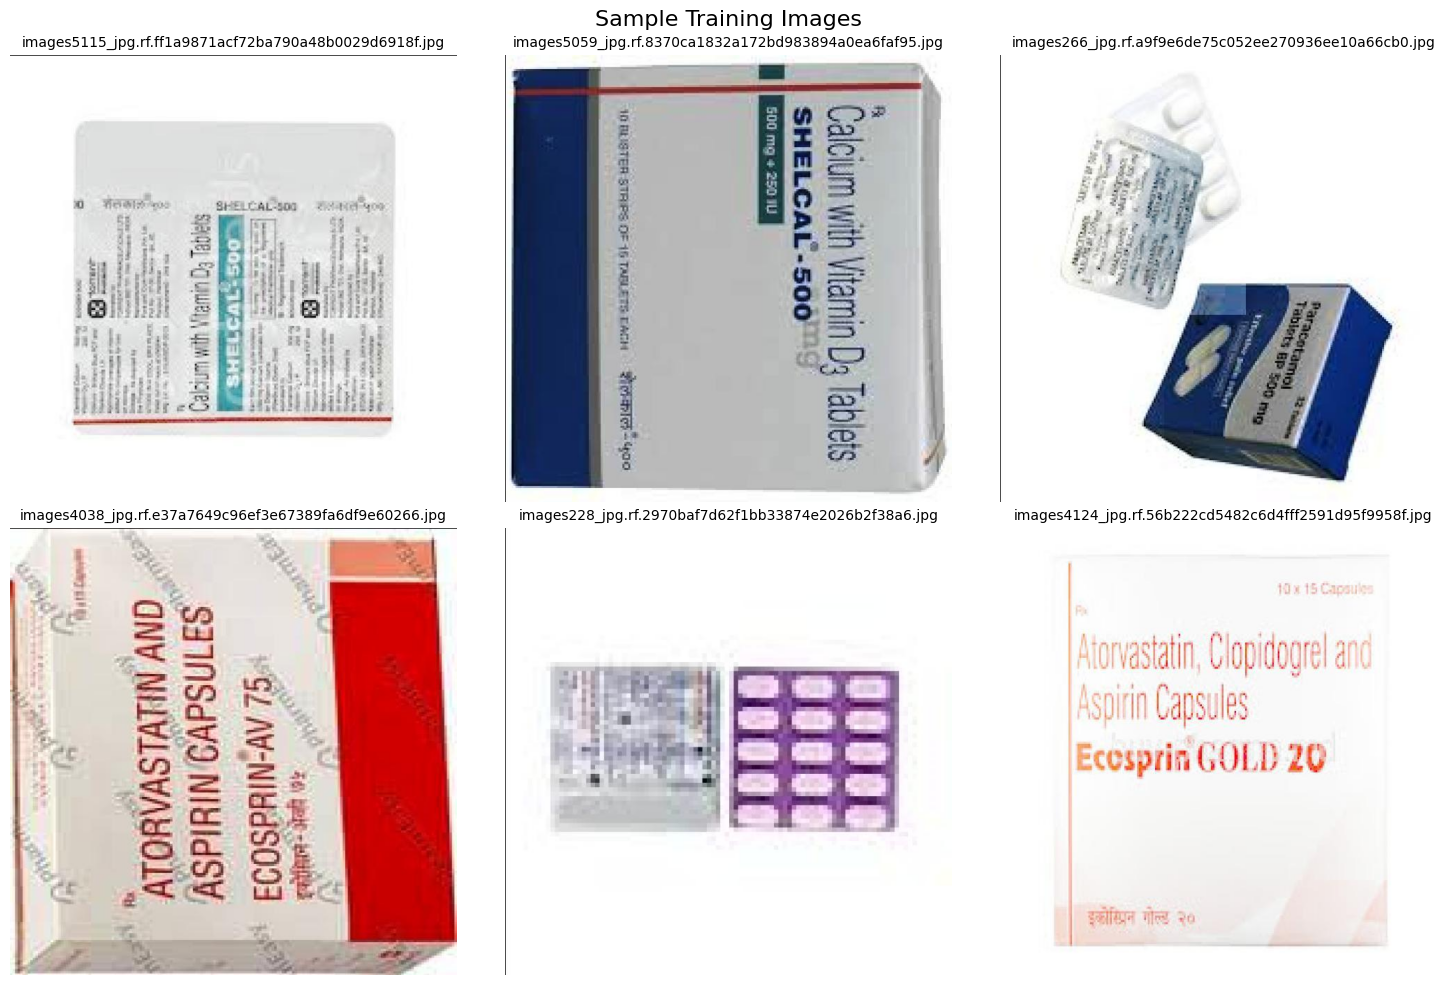

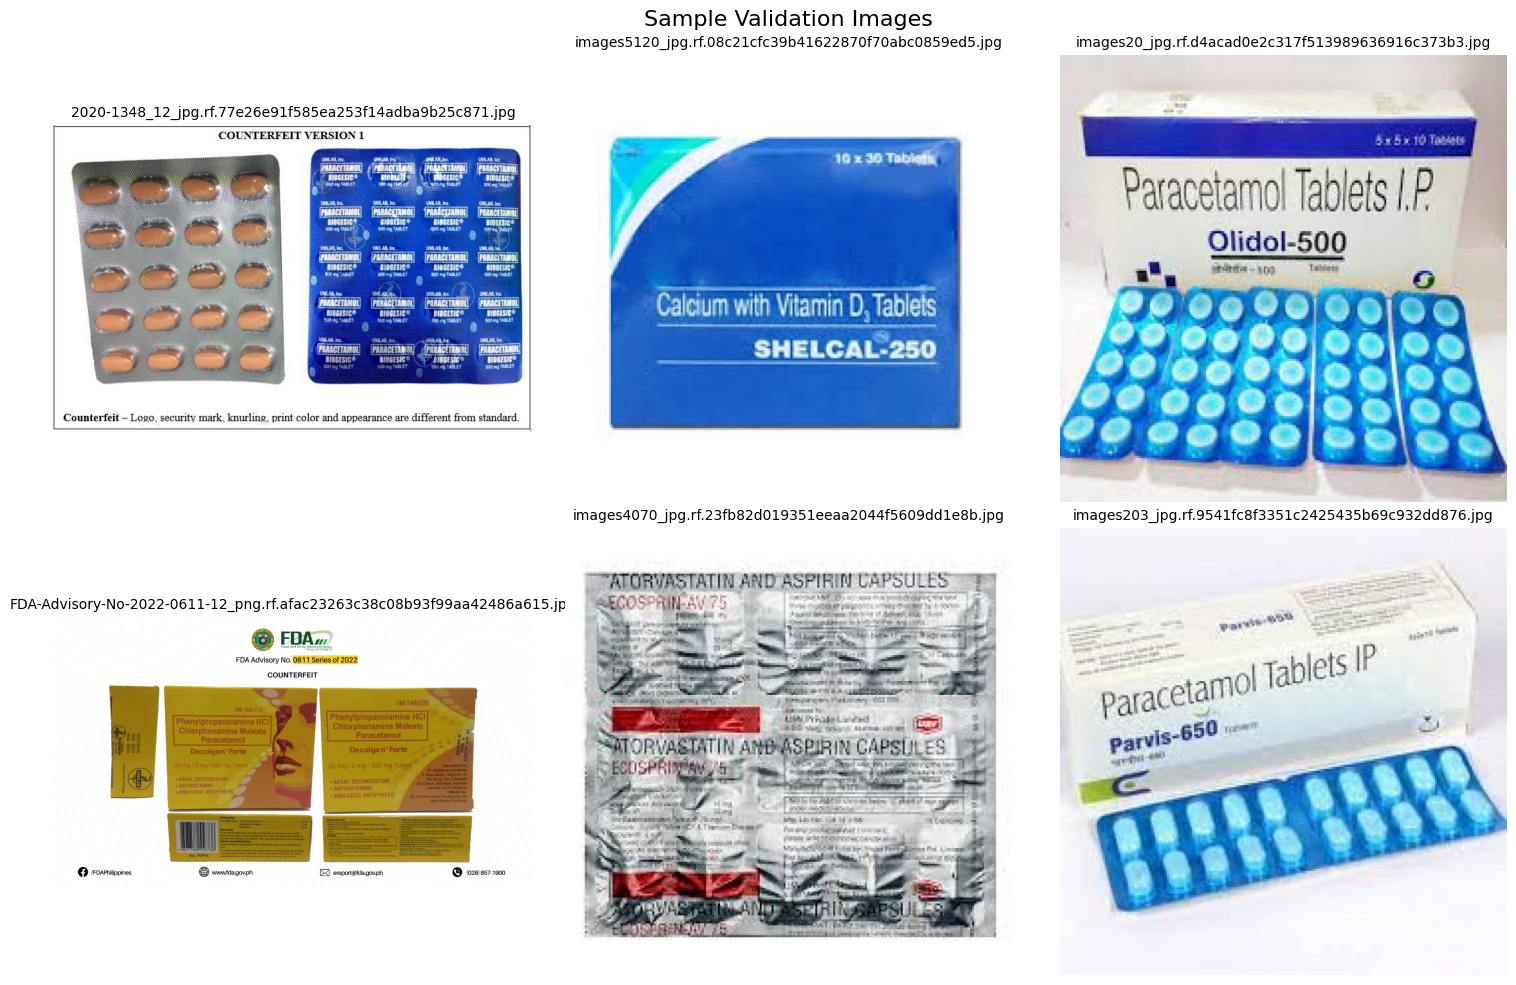

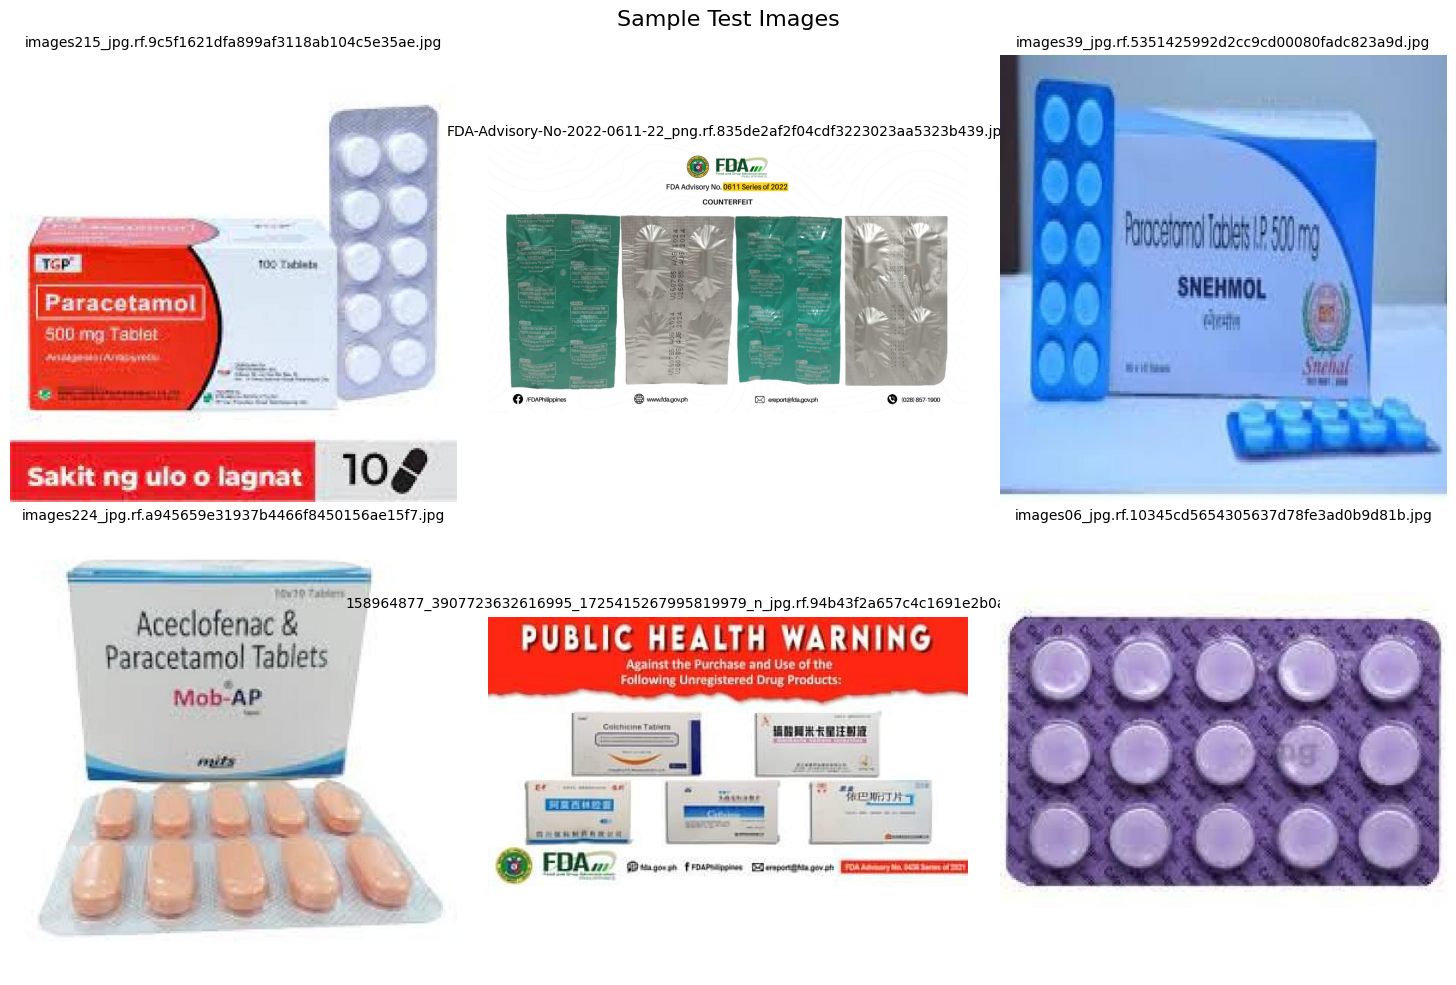

In [4]:
# Simple function to display sample images
def show_sample_images(df, num_samples=6, title=""):
    """
    Display a few sample images from the dataset.
    
    Args:
        df: DataFrame containing image paths
        num_samples: Number of images to display
        title: Title for the plot
    """
    if df is None or len(df) == 0:
        print("No images to display")
        return
    
    # Get unique image paths
    unique_images = df['image_path'].unique()
    num_samples = min(num_samples, len(unique_images))
    
    # Randomly select samples
    sample_paths = np.random.choice(unique_images, size=num_samples, replace=False)
    
    # Create a grid to display images
    cols = 3
    rows = (num_samples + cols - 1) // cols  # Round up division
    
    plt.figure(figsize=(15, 5 * rows))
    if title:
        plt.suptitle(title, fontsize=16)
    
    for i, img_path in enumerate(sample_paths, 1):
        try:
            img = Image.open(img_path)
            plt.subplot(rows, cols, i)
            plt.imshow(img)
            plt.axis('off')
            plt.title(Path(img_path).name, fontsize=10)
        except Exception as e:
            print(f"Could not load image {img_path}: {e}")
    
    plt.tight_layout()
    plt.show()

# Display sample images from each dataset split
if train_df is not None:
    show_sample_images(train_df, num_samples=6, title="Sample Training Images")
    show_sample_images(valid_df, num_samples=6, title="Sample Validation Images")
    show_sample_images(test_df, num_samples=6, title="Sample Test Images")
else:
    print("⚠️ Cannot display images - dataset not loaded")


In [5]:
# Function to create image-level labels from detection boxes
# Rule: If any 'counterfeit' box exists in an image -> label 'counterfeit', else 'authentic'
def create_image_labels(df):
    """
    Convert detection-level labels to image-level labels.
    
    Args:
        df: DataFrame with detection boxes
        
    Returns:
        DataFrame with one label per image
    """
    if df is None:
        return None
    
    # Group by image and get all classes in that image
    image_groups = df.groupby('image_path')['class'].apply(list).reset_index(name='classes')
    
    # Determine label for each image
    def get_label(classes):
        """If any class is 'counterfeit', label the image as counterfeit, else authentic"""
        classes_lower = [str(c).strip().lower() for c in classes]
        return 'counterfeit' if 'counterfeit' in classes_lower else 'authentic'
    
    image_groups['label'] = image_groups['classes'].apply(get_label)
    image_groups['filename'] = image_groups['image_path'].apply(lambda p: Path(p).name)
    
    return image_groups[['image_path', 'filename', 'label']]

# Create image-level labels for all splits
print("Creating image-level labels...")
train_cls = create_image_labels(train_df)
valid_cls = create_image_labels(valid_df)
test_cls = create_image_labels(test_df)

# Display label distribution
if train_cls is not None:
    print("\nLabel distribution:")
    for name, df in [('Training', train_cls), ('Validation', valid_cls), ('Test', test_cls)]:
        if df is not None:
            counts = df['label'].value_counts().to_dict()
            print(f"  {name}: {counts}")
    
    # Get unique classes
    CLASSES = sorted(train_cls['label'].unique().tolist())
    print(f"\n✓ Classification classes: {CLASSES}")
else:
    print("⚠️ Could not create image labels")


Creating image-level labels...

Label distribution:
  Training: {'authentic': 1311, 'counterfeit': 56}
  Validation: {'authentic': 107, 'counterfeit': 16}
  Test: {'authentic': 59, 'counterfeit': 6}

✓ Classification classes: ['authentic', 'counterfeit']


In [6]:
# Create label mappings (convert text labels to numbers)
# Check if CLASSES is defined first
if 'CLASSES' not in globals() or CLASSES is None:
    print("⚠️ Error: CLASSES is not defined.")
    print("Please run the previous cells to create image-level labels first.")
    print("Make sure your dataset path is correct and the data is loaded.")
    print("\nTo fix this:")
    print("1. Check that your dataset path is correct in Cell 3")
    print("2. Make sure the CSV files exist in the train/valid/test folders")
    print("3. Run all cells from the beginning in order")
else:
    # Create label mappings
    LABEL_TO_ID = {name: idx for idx, name in enumerate(CLASSES)}
    ID_TO_LABEL = {idx: name for name, idx in LABEL_TO_ID.items()}
    print(f"✓ Label mapping: {LABEL_TO_ID}")
    
    # Define a custom Dataset class for our images
    class ImageClassificationDataset(Dataset):
        """
        Custom PyTorch Dataset class for image classification.
        """
        def __init__(self, df, transform=None):
            """
            Args:
                df: DataFrame with image paths and labels
                transform: Image transformations to apply
            """
            self.df = df.reset_index(drop=True)
            self.transform = transform
        
        def __len__(self):
            """Return the number of images in the dataset"""
            return len(self.df)
        
        def __getitem__(self, idx):
            """Get one image and its label"""
            row = self.df.iloc[idx]
            
            # Load image
            img = Image.open(row['image_path']).convert('RGB')
            
            # Apply transformations (resize, normalize, etc.)
            if self.transform:
                img = self.transform(img)
            
            # Convert label text to number
            label_id = LABEL_TO_ID[row['label']]
            
            return img, label_id
    
    # Define image transformations
    # Training: includes data augmentation (random flips, color changes) to help model learn better
    train_transforms = T.Compose([
        T.Resize((224, 224)),              # Resize all images to same size
        T.RandomHorizontalFlip(),         # Randomly flip images horizontally
        T.ColorJitter(0.1, 0.1, 0.1, 0.05),  # Randomly adjust brightness, contrast, saturation
        T.ToTensor(),                     # Convert PIL image to tensor
        T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalize
    ])
    
    # Validation/Test: no augmentation, just resize and normalize
    val_transforms = T.Compose([
        T.Resize((224, 224)),
        T.ToTensor(),
        T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    
    # Create datasets
    if train_cls is not None:
        train_dataset = ImageClassificationDataset(train_cls, transform=train_transforms)
        valid_dataset = ImageClassificationDataset(valid_cls, transform=val_transforms)
        test_dataset = ImageClassificationDataset(test_cls, transform=val_transforms)
        
        # Create data loaders (batches of images for training)
        BATCH_SIZE = 32  # Number of images processed at once
        
        train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
        valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False)
        test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)
        
        print(f"\n✓ Datasets created:")
        print(f"  - Training: {len(train_dataset)} images")
        print(f"  - Validation: {len(valid_dataset)} images")
        print(f"  - Test: {len(test_dataset)} images")
    else:
        print("⚠️ Could not create datasets - train_cls is None")


✓ Label mapping: {'authentic': 0, 'counterfeit': 1}

✓ Datasets created:
  - Training: 1367 images
  - Validation: 123 images
  - Test: 65 images


In [7]:
# Check if we have the required variables
if 'CLASSES' not in globals():
    print("⚠️ Please run previous cells first to set up CLASSES")
else:
    # Select device (GPU if available, else CPU)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"✓ Using device: {device}")
    
    # Number of classes (authentic vs counterfeit)
    NUM_CLASSES = len(CLASSES)
    print(f"✓ Number of classes: {NUM_CLASSES} ({CLASSES})")
    
    # Load pre-trained ResNet-18 model
    # This model was trained on millions of images (ImageNet dataset)
    print("\nLoading pre-trained ResNet-18 model...")
    model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
    
    # Replace the final layer to match our number of classes
    # The original model has 1000 output classes, we need only 2 (authentic/counterfeit)
    in_features = model.fc.in_features  # Get the input size of the final layer
    model.fc = nn.Linear(in_features, NUM_CLASSES)  # Replace with our 2-class layer
    
    # Move model to device (GPU or CPU)
    model = model.to(device)
    
    # Define loss function and optimizer
    # Loss function: measures how wrong our predictions are
    criterion = nn.CrossEntropyLoss()
    
    # Optimizer: adjusts model weights to reduce loss
    # Learning rate: how big steps to take when learning
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    
    print("✓ Model created successfully!")
    print("✓ Loss function: CrossEntropyLoss")
    print("✓ Optimizer: Adam (learning rate: 0.001)")


✓ Using device: cpu
✓ Number of classes: 2 (['authentic', 'counterfeit'])

Loading pre-trained ResNet-18 model...
✓ Model created successfully!
✓ Loss function: CrossEntropyLoss
✓ Optimizer: Adam (learning rate: 0.001)


## Step 7: Train the Model

Now we'll train our model. This is where the model learns to distinguish between authentic and counterfeit medicines.



In [ ]:
# Training parameters
EPOCHS = 10  # Number of times we'll go through the entire training dataset
# Use PROJECT_ROOT if defined, otherwise use absolute path
if 'PROJECT_ROOT' in globals():
    MODEL_DIR = PROJECT_ROOT / 'ml_service' / 'model'
else:
    MODEL_DIR = Path('/Users/subhammahapatra/Downloads/Projects/AiMl/ml_service/model')
MODEL_DIR.mkdir(exist_ok=True)
BEST_MODEL_PATH = MODEL_DIR / 'best_cls_resnet18.pt'

# Function to train for one epoch
def train_one_epoch(loader):
    """Train the model for one epoch"""
    model.train()  # Set model to training mode
    total_loss = 0.0
    total_correct = 0
    total_samples = 0
    
    for images, labels in loader:
        # Move data to device (GPU or CPU)
        images = images.to(device)
        labels = labels.to(device)
        
        # Forward pass: get predictions
        optimizer.zero_grad()  # Clear previous gradients
        outputs = model(images)  # Get model predictions
        loss = criterion(outputs, labels)  # Calculate loss
        
        # Backward pass: update model weights
        loss.backward()  # Calculate gradients
        optimizer.step()  # Update weights
        
        # Calculate accuracy
        predictions = outputs.argmax(dim=1)  # Get predicted class
        correct = (predictions == labels).sum().item()
        
        total_correct += correct
        total_samples += labels.size(0)
        total_loss += loss.item()
    
    # Calculate average loss and accuracy
    avg_loss = total_loss / len(loader)
    accuracy = total_correct / total_samples
    return avg_loss, accuracy

# Function to validate for one epoch
def validate_one_epoch(loader):
    """Validate the model"""
    model.eval()  # Set model to evaluation mode
    total_loss = 0.0
    total_correct = 0
    total_samples = 0
    
    with torch.no_grad():  # Don't calculate gradients during validation
        for images, labels in loader:
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            predictions = outputs.argmax(dim=1)
            correct = (predictions == labels).sum().item()
            
            total_correct += correct
            total_samples += labels.size(0)
            total_loss += loss.item()
    
    avg_loss = total_loss / len(loader)
    accuracy = total_correct / total_samples
    return avg_loss, accuracy

# Start training
print("Starting training...")
print(f"Training for {EPOCHS} epochs\n")

best_val_accuracy = 0.0

for epoch in range(1, EPOCHS + 1):
    # Train
    train_loss, train_acc = train_one_epoch(train_loader)
    
    # Validate
    val_loss, val_acc = validate_one_epoch(valid_loader)
    
    # Print progress
    print(f"Epoch {epoch}/{EPOCHS}:")
    print(f"  Train - Loss: {train_loss:.4f}, Accuracy: {train_acc:.4f} ({train_acc*100:.2f}%)")
    print(f"  Valid - Loss: {val_loss:.4f}, Accuracy: {val_acc:.4f} ({val_acc*100:.2f}%)")
    
    # Save best model
    if val_acc > best_val_accuracy:
        best_val_accuracy = val_acc
        torch.save({
            'model_state': model.state_dict(),
            'classes': CLASSES
        }, BEST_MODEL_PATH)
        print(f"  ✓ Saved best model (accuracy: {best_val_accuracy*100:.2f}%)")
    print()

print(f"Training complete!")
print(f"Best validation accuracy: {best_val_accuracy*100:.2f}%")
print(f"Best model saved to: {BEST_MODEL_PATH}")


Starting training...
Training for 10 epochs

Epoch 1/10:
  Train - Loss: 0.1487, Accuracy: 0.9400 (94.00%)
  Valid - Loss: 0.0945, Accuracy: 0.9675 (96.75%)
  ✓ Saved best model (accuracy: 96.75%)



In [ ]:
# Simple function to predict on a single image
def predict_image(image_path):
    """
    Predict the class of a single image.
    
    Args:
        image_path: Path to the image file
        
    Returns:
        predicted_label: The predicted class (authentic or counterfeit)
        confidence: Confidence score (0-1)
    """
    # Load and preprocess image
    img = Image.open(image_path).convert('RGB')
    
    # Apply same transformations as during training
    transform = T.Compose([
        T.Resize((224, 224)),
        T.ToTensor(),
        T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    
    img_tensor = transform(img).unsqueeze(0).to(device)  # Add batch dimension
    
    # Make prediction
    model.eval()
    with torch.no_grad():
        outputs = model(img_tensor)
        probabilities = torch.softmax(outputs, dim=1)[0]  # Get probabilities
        confidence, predicted_idx = torch.max(probabilities, dim=0)
    
    predicted_label = ID_TO_LABEL[int(predicted_idx.item())]
    confidence_score = float(confidence.item())
    
    return predicted_label, confidence_score

# Example: Predict on a test image
# Uncomment and update the path to test on your own image
# image_path = "path/to/your/image.jpg"
# label, confidence = predict_image(image_path)
# print(f"Prediction: {label}")
# print(f"Confidence: {confidence:.2%}")

print("✓ Prediction function ready!")
print("To use it, call: predict_image('path/to/image.jpg')")


In [ ]:
# Load the best model
print("Loading best model for evaluation...")
if BEST_MODEL_PATH.exists():
    checkpoint = torch.load(BEST_MODEL_PATH, map_location=device)
    model.load_state_dict(checkpoint['model_state'])
    model.eval()
    print(f"✓ Loaded model from {BEST_MODEL_PATH}")
else:
    print("⚠️ Model file not found. Using current model weights.")

# Evaluate on test set
print("\nEvaluating on test set...")
all_predictions = []
all_labels = []

model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        
        outputs = model(images)
        predictions = outputs.argmax(dim=1)
        
        all_predictions.extend(predictions.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Calculate accuracy
correct = sum(p == l for p, l in zip(all_predictions, all_labels))
total = len(all_labels)
test_accuracy = correct / total

print(f"\n✓ Test Results:")
print(f"  Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
print(f"  Correct: {correct}/{total}")

# Confusion Matrix
print("\nConfusion Matrix:")
cm = confusion_matrix(all_labels, all_predictions)
print(cm)
print(f"\nRows = True labels, Columns = Predicted labels")
print(f"Classes: {CLASSES}")

# Classification Report
print("\nDetailed Classification Report:")
print(classification_report(all_labels, all_predictions, target_names=CLASSES))
